**Diffusion equation with hard initial and boundary conditions**

Retyped by Theodoret Putra Agatho on 5 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.exactBC.html)

In [ ]:
pip install deepxde

**Problem setup**

We will solve a diffusion equation:

\begin{align}
        \frac{\partial y}{\partial t} = \frac{\partial ^2 y}{\partial x^2} - e^{-t} (sin(\pi x) - \pi ^2 sin((\pi x)), x \in [-1,1], t \in [0,1]
    \end{align}

with the initial condition

\begin{align}
        y(x, 0) = sin(\pi x).
    \end{align}

and the Dirichlet boundary condition

\begin{align}
        y(-1,t) = y(1,t) = 0.
    \end{align}

The reference solution is $y = e^{-t}sin(\pi x)$.

**Implementation**

This description goes through the implementation of a solver for the above described diffusion equation step-by-step.

First, the DeepXDE, NumPy (`np`), and TensorFlow (`tf`) modules are imported:

In [ ]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term



We begin by defining computational geometries. We can use a built-in-class `interval` and `TimeDomain` and we combine both the domains using `GeometryXTime` as follows

In [ ]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Next, we express the PDE residual of the diffusion equation:

In [ ]:
def pde(x, y):
  dy_t = dde.grad.jacobian(y, x, j=1)
  dy_xx = dde.grad.hessian(y, x, j=0)
  return (
      dy_t
      - dy_xx
      + tf.exp(-x[:, 1:])
      * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
  )

The first argument to `pde` is 2-dimenasional vector where the first component(`x[:,0:1]`) is $x$-coordinate and the second component(`x[:,1:]`) is the $t$-coordinate. The second argument is the network output, i.e., the solution $y(x, t)$.

The reference solution `func` is defined as:

In [ ]:
def func(x):
  return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

Now, we have specified the geometry and the PDE residual. However, in order to apply hard boundary and initial conditions, they are not specified and exclluded from the loss function. We then define the `TimePDE` problem as

In [ ]:
data = dde.data.TimePDE(geomtime, pde, [], num_domain=40, solution=func, num_test=10000)

The number 40 is the number of training residual points sampled inside the domain. 10000 points for testing the PDE residual.

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers and width 32:

In [ ]:
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Then we construct a function that spontaneously satisfies both the initial and the boundary conditions to transform the network output. In this case, $t(1 - x^2)y + sin(\pi x)$ is used. When $t$ is equal to 0, the initial condition $sin(\pi x)$ is recovered. When x is equal to -1 or 1, the boundary condition $y(-1, t) = y(1, t) = 0$ is recovered. Hence the initial and boundary conditions are both hard conditions.

In [ ]:
net.apply_output_transform(
    lambda x, y: x[:, 1:2] * (1 - x[:, 0:1] ** 2) * y + tf.sin(np.pi * x[:, 0:1])
)

Now, we have the PDE problem and the network. We build a `Model` and choose the optimizer and learning rate. We then train the model for 10000 iterations.

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.417391 s

'compile' took 2.549851 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.25e+01]    [1.31e+01]    [7.05e-01]    
1000      [2.61e-03]    [3.03e-03]    [5.09e-03]    
2000      [3.66e-04]    [4.94e-04]    [1.76e-03]    
3000      [5.35e-05]    [2.18e-04]    [6.36e-04]    
4000      [5.32e-05]    [2.18e-04]    [1.21e-03]    
5000      [2.38e-05]    [1.53e-04]    [5.54e-04]    
6000      [1.75e-05]    [1.33e-04]    [5.21e-04]    
7000      [3.79e-04]    [5.71e-04]    [6.49e-03]    
8000      [8.20e-04]    [1.06e-03]    [9.47e-03]    
9000      [8.67e-06]    [1.10e-04]    [5.08e-04]    
10000     [7.00e-06]    [1.11e-04]    [4.95e-04]    

Best model at step 10000:
  train loss: 7.00e-06
  test loss: 1.11e-04
  test metric: [4.95e-04]

'train' took 32.296963 s



We also save and plot the best trained result and loss history.

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


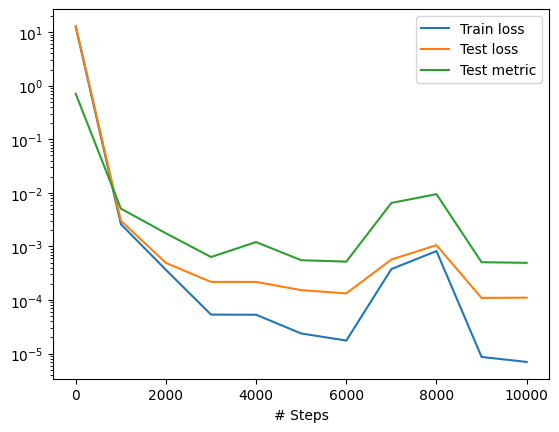

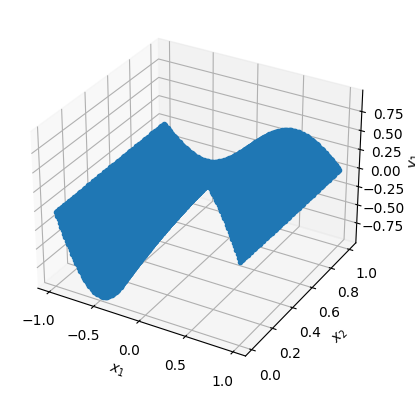

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)